## 4.6　専門家知識の利用

専門家知識（その分野に特化した知識）を利用することは、特徴量エンジニアリングにとって大いに役に立つケースがある。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

Andressの家の前にあるレンタルサイクリングステーションに関するデータについて見てみる。

In [2]:
citibike = mglearn.datasets.load_citibike()

print(citibike.shape)
pd.DataFrame(citibike).head()

(248,)


,one
starttime,
2015-08-01 00:00:00,3
2015-08-01 03:00:00,0
2015-08-01 06:00:00,9
2015-08-01 09:00:00,41
2015-08-01 12:00:00,39


レンタル頻度を可視化する。

Text(0, 0.5, 'Rentals')

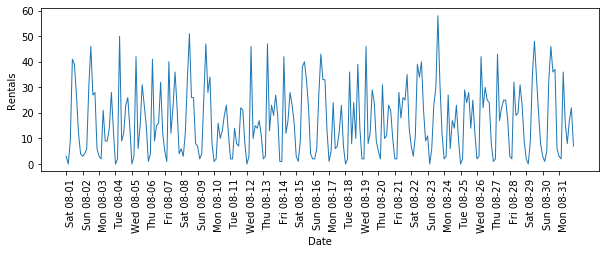

In [3]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime('%a %m-%d'), rotation=90, ha='left')
plt.plot(citibike, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Rentals')

rotationは、横で表示されるticksラベルを90°回転させている。

In [4]:
y = citibike.values
X = citibike.index.astype('int64').to_numpy().reshape(-1, 1) // 10**9

In [5]:
print(X.shape)
pd.DataFrame(X).head()

(248, 1)


,0
0,1438387200
1,1438398000
2,1438408800
3,1438419600
4,1438430400


In [6]:
print(y.shape)
pd.DataFrame(y).head()

(248,)


,0
0,3
1,0
2,9
3,41
4,39


In [7]:
n_train = 184

def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    
    regressor.fit(X_train, y_train)
    print('Test-set R^2: {:.2f}'.format(regressor.score(X_test, y_test)))
    
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.xticks(range(0, len(X), 8), xticks.strftime('%a %m-%d'), rotation=90, ha='left')
    plt.plot(range(n_train), y_train, label='train')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label='test')
    plt.plot(range(n_train), y_pred_train, '-', label='prediction train')
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '-', label='prediction test')
    plt.legend(loc=(1.01, 0))
    plt.xlabel('Date')
    plt.ylabel('Rentals')

In [8]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

Test-set R^2: -0.04


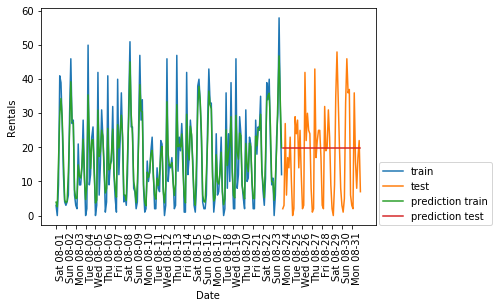

In [9]:
eval_on_features(X, y, regressor)

テストセットの時刻は、訓練データのレンジから外れている。<br>
この場合、決定木は最後に予測した値を出力するため、prediction testは直線のプロットを描いている。

ここで、1日の中の時刻だけを使用してみる。

In [10]:
X_hour = citibike.index.hour.to_numpy().reshape(-1, 1)

pd.DataFrame(X_hour, columns=['time']).head(10)

,time
0,0
1,3
2,6
3,9
4,12
5,15
6,18
7,21
8,0
9,3


Test-set R^2: 0.60


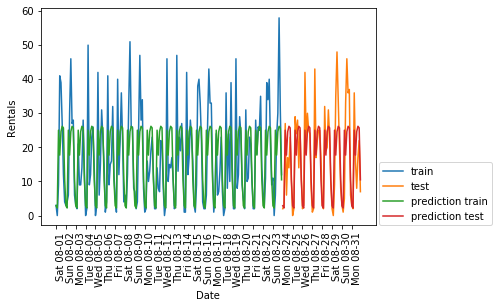

In [11]:
eval_on_features(X_hour, y, regressor)

この予測は1週間の周期を見落としているので、曜日情報を加えてみる。

In [12]:
X_hour_week = np.hstack([citibike.index.dayofweek.to_numpy().reshape(-1, 1), citibike.index.hour.to_numpy().reshape(-1, 1)])

pd.DataFrame(X_hour_week, columns=['Day of the week', 'time']).head()

,Day of the week,time
0,5,0
1,5,3
2,5,6
3,5,9
4,5,12


Test-set R^2: 0.84


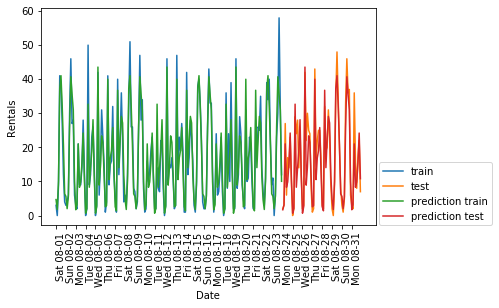

In [13]:
eval_on_features(X_hour_week, y, regressor)

より簡単なモデルであるLinearRegressionでも試してみる。

Test-set R^2: 0.13


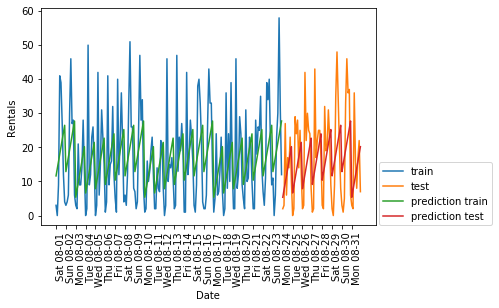

In [14]:
eval_on_features(X_hour_week, y, LinearRegression())

線形回帰の予測性能は非常に悪い。これは、曜日や時刻が整数でエンコードされていて、連続値として解釈されているためである。<br>
OneHotEncodingでカテゴリ変数として扱えば、パターンを捉えることができる。

In [15]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

print(X_hour_week_onehot.shape)
pd.DataFrame(X_hour_week_onehot).head()

(248, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Test-set R^2: 0.62


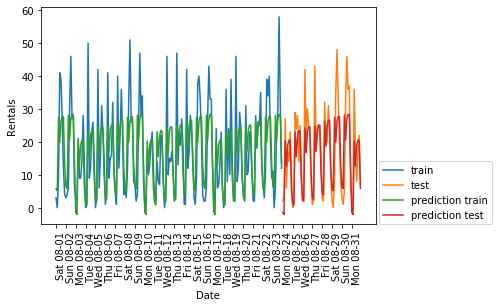

In [16]:
eval_on_features(X_hour_week_onehot, y, Ridge())

ここで、交互作用特徴量を用いて、曜日と時刻の組み合わせに対して係数を学習させる。

In [17]:
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)

print(X_hour_week_onehot_poly.shape)
pd.DataFrame(X_hour_week_onehot_poly).head()

(248, 120)


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


下記のように、最初に特徴量の累乗、次に特徴量同士の積を使用している。

In [33]:
pd.DataFrame(poly_transformer.get_feature_names())

,0
0,x0
1,x1
2,x2
3,x3
4,x4
...,...
115,x11 x13
116,x11 x14
117,x12 x13
118,x12 x14


Test-set R^2: 0.85


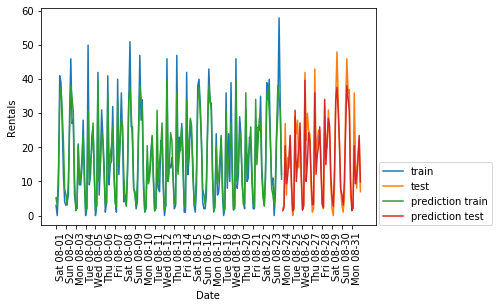

In [20]:
lr = Ridge()

eval_on_features(X_hour_week_onehot_poly, y, lr)

このモデルの長所は、ランダムフォレストと違って、曜日と時刻の組み合わせに対して係数が1つな点である。<br>
学習した係数をプロットすることができる。

最初に、時刻と曜日の特徴量に名前をつける。

In [21]:
hour = ['%02d:00' % i for i in range(0, 24, 3)]
day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

features = day + hour

print(hour)
print(day)

['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']
['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


「PolynomialFeaturesで抽出した交互作用特徴量」に対して名前（features_poly）を付ける。

In [29]:
features_poly = poly_transformer.get_feature_names(features)

pd.DataFrame(features_poly)

,0
0,Mon
1,Tue
2,Wed
3,Thu
4,Fri
...,...
115,12:00 18:00
116,12:00 21:00
117,15:00 18:00
118,15:00 21:00


係数が非ゼロの特徴量だけを残す。

In [28]:
features_nonzero = np.array(features_poly)[lr.coef_ != 0]

pd.DataFrame(features_nonzero)

,0
0,Mon
1,Tue
2,Wed
3,Thu
4,Fri
...,...
66,Sun 09:00
67,Sun 12:00
68,Sun 15:00
69,Sun 18:00


傾きに数値変換する。

In [30]:
coef_nonzero = lr.coef_[lr.coef_ != 0]

pd.DataFrame(coef_nonzero)

,0
0,-4.167247
1,-1.595819
2,-0.524390
3,-0.060105
4,1.225610
...,...
66,5.721064
67,13.362009
68,7.862796
69,3.547835


Text(0, 0.5, 'Feture magnitude')

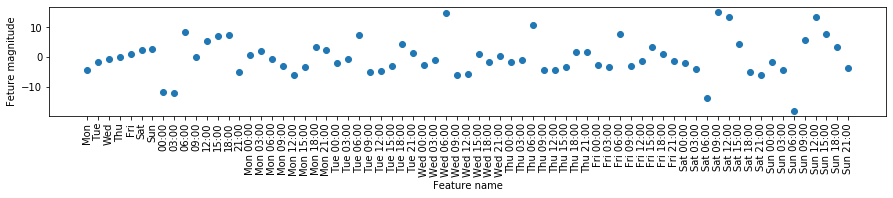

In [31]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel('Feature name')
plt.ylabel('Feture magnitude')

In [38]:
pd.DataFrame(np.arange(len(coef_nonzero)))

,0
0,0
1,1
2,2
3,3
4,4
...,...
66,66
67,67
68,68
69,69


これにより、時刻と曜日の席を用いた線形回帰モデルの係数を可視化することができた。